Lmax= 125 C = 4.9704633813763006e-05


Text(0.5, 1.0, 'Bioscreen Contaminant Concentration')

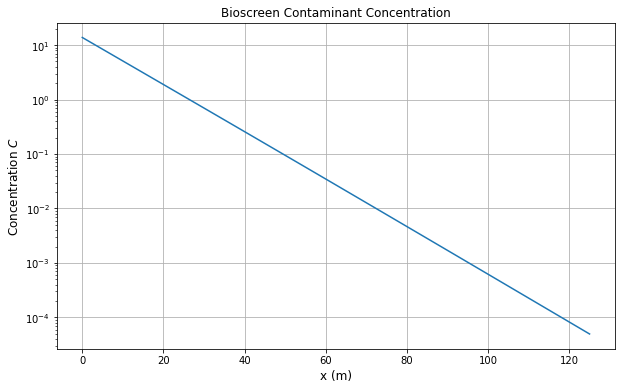

In [90]:
import numpy as np
import scipy as sp
from scipy import special
import matplotlib.pyplot as plt

## Input Parameters
Cthres = 5e-5               #[mg/l]       Input Box (lower limit: >0, upper limit: <Co)

# time
t = 100                      #[y]          Input Box (Default = 20, if below 15, use: (1/la)+5,  upper limit 1000)

# Geometry - centreline
y = 0                       #[m]          fixed (no Input)
z_1 = 0                     #[m]          fixed (no input)
z_2 = 3.048                    #[m]          Input slider (lower limit: >0, upper limit:50)   (A.T.)

# Source term
Co =13.8                     #[mg/l]       Input slider (lower limit: >0, upper limit:1000)  (source conc.)
z = (z_1+z_2)/2             #[m]          fixed (no Input)
W = 15.24                     #[m]          Input slider (lower limit: >0, upper limit:1000)  (Sorce width)

# hydraulic & mixing
v = 2.52288                      #[m/y]        Input Box (lower limit: 10, upper limit: 1000)
al_x = 10                   #[m]          Input slider (lower limit: 1, upper limit: 100, default: 10) (long. disp.)
al_y = 0.1                  #[m]          Input Box (lower limit: 0.1, upper limit: 10, default: 0.5)  (Horizontal trans. disp.)
al_z = 0.01                #[m]          Input Box (lower limit: 0.01, upper limit: 1, default: 0.05) (vertical trans. disp.)
Df = 0                      #[m^2/y]      Input Box (lower limit: 0 upper limit: 0.1, default: 0)  (eff.diffusion coeff. )

# reaction terms
R = 1                       #[-]          Input Box (lower limit: 1, upper limit:100, default: 1)  (retardation factor)
ga = 0                      #[1/y]        Input Box (lower limit: 0, upper limit: 1, default: 0) (source decay coeff.)
la = 5e-1               #[1/y]        Input slider (lower limit: 0, upper limit: 1, default: 0.1) (eff first order decay coeff.)

# Gauss points: max 256
m = 256                     #[-]          Input Box (possible values: 4,5,6,10,15,20,60,104,256; default: 60)

Dx = al_x*v + Df            #[m^2/y]
Dy = al_y*v + Df            #[m^2/y]
Dz = al_z*v + Df             #[m^2/y]

# used data
vr = v/R                    #[m/y]
Dyr = Dy/R                  #[m^2/y]
Dxr = Dx/R                  #[m^2/y]
Dyr = Dy/R                  #[m^2/y]
Dzr = Dz/R                  #[m^2/y]



def C(x):
    
    # Boundary Condition
    
    if x<=1e-6:
        if y <= W/2 and y >= -W/2 and z <= z_2 and z >= z_1:
            C=Co*np.exp(-ga*t)
        else:
            C=0
    else:
        
        a = Co*np.exp(-ga*t)*x/(8*np.sqrt(np.pi*Dxr))
    
    
        roots = sp.special.roots_legendre(m)[0]
        weights = sp.special.roots_legendre(m)[1]
    

        #scaling
    
        bot = 0
        top = np.sqrt(np.sqrt(t))
    
        Tau = (roots*(top-bot)+top+bot)/2
        Tau4= Tau**4

        #calculation
            
        xTerm = (np.exp(-(((la-ga)*Tau4)+((x-vr*Tau4)**2)/(4*Dxr*Tau4))))/(Tau**3)
    
        yTerm = sp.special.erfc((y-W/2)/(2*np.sqrt(Dyr*Tau4))) - sp.special.erfc((y+W/2)/(2*np.sqrt(Dyr*Tau4)))
    
        zTerm = sp.special.erfc((z-z_2)/(2*np.sqrt(Dzr*Tau4))) - sp.special.erfc((z-z_1)/(2*np.sqrt(Dzr*Tau4)))
    
        Term = xTerm * yTerm * zTerm
    
        Integrand = Term*(weights*(top-bot)/2)
    
        C = a*4*sum(Integrand)
        
    return C

x_array = np.array([0])
c_array = np.array([C(0)])
x = 0
while C(x) >= Cthres and x<100000:
    x = x+1
    x_array = np.append(x_array,x)
    c_array = np.append(c_array,C(x))
else:
    print('Lmax=',x, 'C =',C(x))
    np.savetxt('Output', np.column_stack((x_array, c_array)))



plt.figure(figsize=(10,6))
plt.plot(x_array, c_array)
plt.yscale('log')
plt.xlabel(r"x (m)", fontsize = 12 ); plt.ylabel(r"Concentration $C$", fontsize = 12);
plt.grid()
plt.title('Bioscreen Contaminant Concentration')
